In [1]:
#packages
using Pkg #package manager
Pkg.activate(".") #applies any following packages to this directory

  Activating project at `~/Projects/Indistinguishability-Repo`


In [83]:
#Relevant packages
using LinearAlgebra;
using CairoMakie;
using StatsBase;
using DataFrames;
using CSV;
using XLSX;
using BlackBoxOptim;
using SpecialFunctions;

In [19]:
#function to compute the predicted values given by a specified regression model for specified parameters and range
function compute_mean_reg(model_func, params, x_range)
    y_vec = Vector{Float64}();
    for x in x_range
        y = model_func(x, params);
        push!(y_vec, y);
    end
    return y_vec;
end

compute_mean_reg (generic function with 1 method)

In [ ]:
#form of the model

#power law with delay
function m(t, p)
    if t < p[3]
        return p[4];
    else
        return p[4] + (p[1]/gamma(p[2]+1))*((t-p[3]).^p[2]);
    end
end

#power law with no delay
function m(t, p)
    return p[3] + (p[1]/gamma(p[2]+1))*(t.^p[2]);
end

In [53]:
#Yeast Data

#import CY5 Exp1 single cell data
println("scData_Exp1_CY5_nuclear.xlsx")
println("scData_Exp1_CY5_cytoplasm.xlsx")
df_nuclear = DataFrame(XLSX.readtable("scData_Exp1_CY5_nuclear.xlsx", "Sheet1"));
df_nuclear = df_nuclear[:,1:8];
df_cytoplasm = DataFrame(XLSX.readtable("scData_Exp1_CY5_cytoplasm.xlsx", "Sheet1"));
df_cytoplasm= df_cytoplasm[:,1:8];

#compute mean at each time point
n_cells_vec = Vector{Int64}();
nuclear_means_vec = Vector{Float64}();
cytoplasm_means_vec = Vector{Float64}();
times_vec = [0.0, 1.0, 2.0, 4.0, 6.0, 8.0, 10.0, 15.0];
for j in 1:1:(size(df_nuclear)[2])
    #find "number of cells/samples" - i.e. find the number of non-missing values
    len = length(df_nuclear[:,j]);
    notmissing_idxs = findall(x -> ismissing(df_nuclear[:,j][x])==false, collect(1:1:len));
    n_cells = length(notmissing_idxs);
    push!(n_cells_vec, n_cells);
    temp_mean_N = mean(df_nuclear[notmissing_idxs,j]);
    temp_mean_C = mean(df_cytoplasm[notmissing_idxs,j]);
    push!(nuclear_means_vec, temp_mean_N);
    push!(cytoplasm_means_vec, temp_mean_C);
end

scData_Exp1_CY5_nuclear.xlsx
scData_Exp1_CY5_cytoplasm.xlsx


In [54]:
#optimisation - estimate parameters

#fit cytoplasmic data
#infer delay
#then use this delay to fit nuclear data

#Cytoplasmic mRNA
   
#define full cyoplasmic mRNA model
function m_C(t, p)
    if t < p[3]
        return p[4];
    else
        return p[4] + (p[1]/gamma(p[2]+1))*((t-p[3]).^p[2]);
    end
end
#p[1] - prefactor - A_C
#p[2] - exponent - n_C
#p[3] - delay - t_0
#p[4] - constant cytoplasmic mRNA during delay m0_C

#choose the number of timepoints to use
N_timepoints_C = 6;
x_ = times_vec[1:N_timepoints_C];
y_ = cytoplasm_means_vec[1:N_timepoints_C];
model_func = m_C;

#construct a function which computes the RSS for a given set of model parameters
#the covariates (x_), responses (y_) and regression model (model_func) all need to be predefined
#pass function a vector of model parameters (p_vec)
function RSS_C(p_vec)

    #compute predicted values
    y_pred = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_pred = model_func(x_[i], p_vec);
        push!(y_pred, temp_pred);
    end

    #compute residuals
    resid = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_resid = y_[i] - y_pred[i];
        push!(resid, temp_resid);
    end

    #compute residual sum of squares (RSS)
    rss_value = sum(resid .^ 2);

    return rss_value;

end

#Optimisation!

#p[1] - prefactor - A_C - bounds: (0.0, 10^10)
#p[2] - exponent - n_C - bounds: (0.0, 10.0)
#p[3] - delay - t_0 - bounds: (0.0, 1.0)
#p[4] - constant cytoplasmic mRNA during delay - m0_C - bounds: (0.0, 1.0)
optim_res_C = bboptimize(RSS_C; SearchRange = [(0.0, 10^3), (1.0, 9.0), (0.0, 4.5), (0.0, 1.5)], MaxSteps=5*10^5, TraceMode=:compact);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 198596 evals, 198918 steps, improv/step: 0.114 (last = 0.1138), fitness=0.022647921
1.00 secs, 390137 evals, 390840 steps, improv/step: 0.106 (last = 0.0970), fitness=0.022647921

Optimization stopped after 500001 steps and 1.27 seconds
Termination reason: Max number of steps (500000) reached
Steps per second = 393224.77
Function evals per second = 392496.52
Improvements/step = 0.10329
Total function evaluations = 499075


Best candidate found: [0.578281, 2.90388, 2.28576, 0.447902]

Fitness: 0.022647921



In [55]:
#Nuclear mRNA

t_0 = best_candidate(optim_res_C)[3];
println("t_0 = ", t_0)

#define full nuclear mRNA model
function m_N(t, p)
    if t < t_0
        return p[3];
    else
        return p[3] + (p[1]/gamma(p[2]+1))*((t-t_0).^p[2]);
    end
end
#p[1] - prefactor - A_N
#p[2] - exponent - n_N
#p[3] - constant nuclear mRNA during delay - m0_N

#define beforehand
N_timepoints_N = 5;
x_ = times_vec[1:N_timepoints_N];
y_ = nuclear_means_vec[1:N_timepoints_N];
model_func = m_N;

#construct a function which computes the RSS for a given set of model parameters
#the covariates (x_), responses (y_) and regression model (model_func) all need to be predefined
#pass function a vector of model parameters (p_vec)
function RSS_N(p_vec)

    #compute predicted values
    y_pred = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_pred = model_func(x_[i], p_vec);
        push!(y_pred, temp_pred);
    end

    #compute residuals
    resid = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_resid = y_[i] - y_pred[i];
        push!(resid, temp_resid);
    end

    #compute residual sum of squares (RSS)
    rss_value = sum(resid .^ 2);

    return rss_value;

end

#Optimisation!

#p[1] - prefactor - A_N
#p[2] - exponent - n_N
#p[3] - constant nuclear mRNA during delay - m0_N
optim_res_N = bboptimize(RSS_N; SearchRange = [(0.0, 10^3), (1.0, 9.0), (0.0, 0.5)], MaxSteps=5*10^5, TraceMode=:compact);

t_0 = 2.2857557968446187
Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 141136 evals, 141106 steps, improv/step: 0.256 (last = 0.2562), fitness=0.000004946
1.00 secs, 290475 evals, 290502 steps, improv/step: 0.256 (last = 0.2564), fitness=0.000004946
1.50 secs, 426472 evals, 426544 steps, improv/step: 0.258 (last = 0.2609), fitness=0.000004946

Optimization stopped after 500001 steps and 1.76 seconds
Termination reason: Max number of steps (500000) reached
Steps per second = 283965.65
Function evals per second = 283909.99
Improvements/step = 0.25784
Total function evaluations = 499903


Best candidate found: [0.056272, 1.92804, 0.0144793]

Fitness: 0.000004946



In [56]:
#estimates

#cytoplasmic mRNA
prefactor_C = best_candidate(optim_res_C)[1]; #prefactor
println("cytoplasmic prefactor = ", prefactor_C) 
exponent_C = best_candidate(optim_res_C)[2]; #exponent
println("cytoplasmic exponent = ", exponent_C)
t_0 = best_candidate(optim_res_C)[3]; #delay
println("delay = ", t_0)
m0_C = best_candidate(optim_res_C)[4]; #m_0C
println("m_0C = ", m0_C);
println()

#nuclear mRNA
prefactor_N = best_candidate(optim_res_N)[1]; #prefactor
println("nuclear prefactor = ", prefactor_N) 
exponent_N = best_candidate(optim_res_N)[2]; #exponent
println("nuclear exponent = ", exponent_N)
m0_N = best_candidate(optim_res_N)[3]; #m_0N
println("m_0N = ", m0_N);

cytoplasmic prefactor = 0.5782806604514041
cytoplasmic exponent = 2.9038809306982385
delay = 2.2857557968446187
m_0C = 0.44790197241232405

nuclear prefactor = 0.056272028733302275
nuclear exponent = 1.9280406905881888
m_0N = 0.014479250660990818


In [57]:
#compute regression using optimal parameters and model

x_range_N = 0.0:0.1:times_vec[N_timepoints_N];
optim_ps_vec_N = best_candidate(optim_res_N);
nuclear_mean_reg = compute_mean_reg(m_N, optim_ps_vec_N, x_range_N);

x_range_C = 0.0:0.1:times_vec[N_timepoints_C];
optim_ps_vec_C = best_candidate(optim_res_C);
cytoplasm_mean_reg = compute_mean_reg(m_C, optim_ps_vec_C, x_range_C);

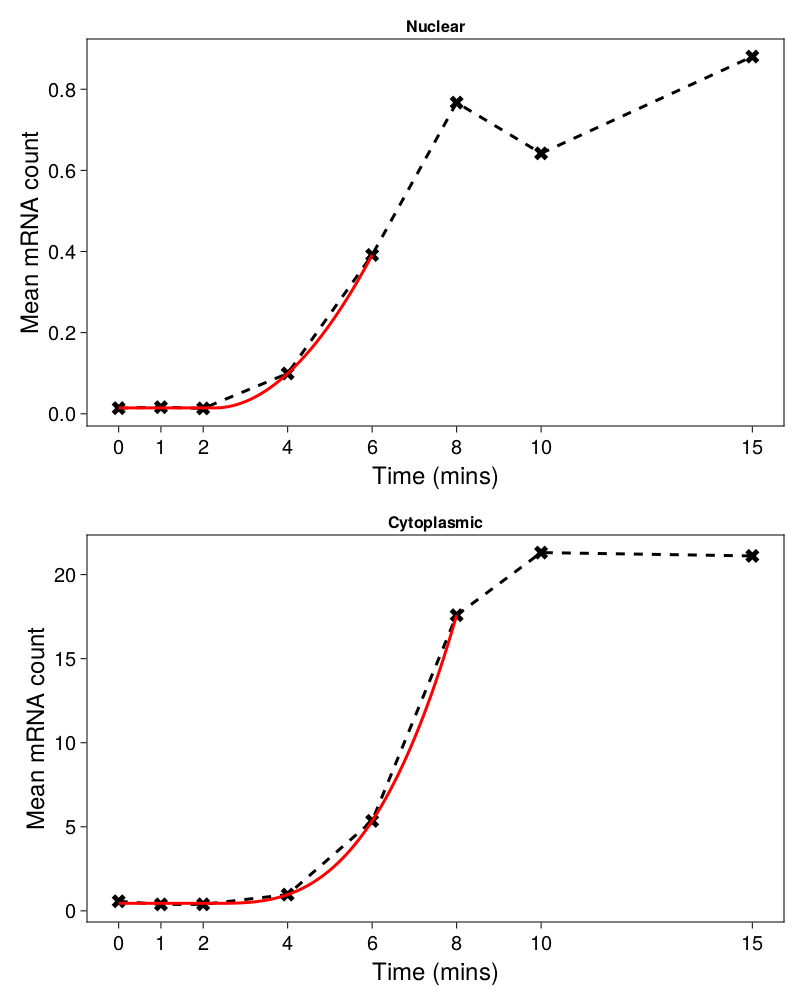

In [58]:
#plot nuclear and cytoplasmic mean mRNA count curves and regressions

fig_1 = Figure(resolution = (800, 1000))

#Data curve
ax = Axis(fig_1[1,1], xlabel="Time (mins)", ylabel="Mean mRNA count",
          xlabelsize=24, xticklabelsize=20, ylabelsize=24, yticklabelsize=20, title="Nuclear", xticks=[0,1,2,4,6,8,10,15])
CairoMakie.scatterlines!(times_vec, nuclear_means_vec, color=:black, marker=:xcross, markersize=20, linewidth=3, linestyle=:dash)
CairoMakie.lines!(x_range_N, nuclear_mean_reg, color=:red, linewidth=3)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

#Data curve
ax = Axis(fig_1[2,1], xlabel="Time (mins)", ylabel="Mean mRNA count",
          xlabelsize=24, xticklabelsize=20, ylabelsize=24, yticklabelsize=20, title="Cytoplasmic", xticks=[0,1,2,4,6,8,10,15])
CairoMakie.scatterlines!(times_vec, cytoplasm_means_vec, color=:black, marker=:xcross, markersize=20, linewidth=3, linestyle=:dash)
CairoMakie.lines!(x_range_C, cytoplasm_mean_reg, color=:red, linewidth=3)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)

fig_1

In [60]:
#Mouse data

#import data
filename = "Data_A_g2_Icam1_J2_mRNA.csv";
df_mRNA = CSV.read(filename, DataFrame);
times_vec_2 = df_mRNA[:,1].*60.0; #convert times from hours to minutes
RNAcount_vec = df_mRNA[:,2];

In [61]:
#optimisation - estimate parameters

#define model
function m(t, p)
    if t < p[3]
        return p[4];
    else
        return p[4] + (p[1]/gamma(p[2]+1))*((t-p[3]).^p[2]);
    end
end
#p[1] - prefactor - A_C
#p[2] - exponent - n_C
#p[3] - delay - t_0
#p[4] - constant mRNA during delay m0

#choose the number of timepoints to use
N_timepoints = 6;
x_ = times_vec_2[1:N_timepoints];
y_ = RNAcount_vec[1:N_timepoints];
model_func = m;

#construct a function which computes the RSS for a given set of model parameters
#the covariates (x_), responses (y_) and regression model (model_func) all need to be predefined
#pass function a vector of model parameters (p_vec)
function RSS(p_vec)

    #compute predicted values
    y_pred = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_pred = model_func(x_[i], p_vec);
        push!(y_pred, temp_pred);
    end

    #compute residuals
    resid = Vector{Float64}();
    for i in 1:1:length(y_)
        temp_resid = y_[i] - y_pred[i];
        push!(resid, temp_resid);
    end

    #compute residual sum of squares (RSS)
    rss_value = sum(resid .^ 2);

    return rss_value;

end

#Optimisation!

#p[1] - prefactor - A
#p[2] - exponent - n
#p[3] - delay - t_0
#p[4] - constant mRNA during delay - m0
optim_res = bboptimize(RSS_C; SearchRange = [(0.0, 10^3), (1.0, 9.0), (0.0, 15.0), (0.0, 5.0)], MaxSteps=5*10^5, TraceMode=:compact);

Starting optimization with optimizer DiffEvoOpt{FitPopulation{Float64}, RadiusLimitedSelector, BlackBoxOptim.AdaptiveDiffEvoRandBin{3}, RandomBound{ContinuousRectSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.50 secs, 192804 evals, 217256 steps, improv/step: 0.644 (last = 0.6439), fitness=0.643438845
1.00 secs, 390565 evals, 444113 steps, improv/step: 0.695 (last = 0.7433), fitness=0.643438845

Optimization stopped after 500001 steps and 1.11 seconds
Termination reason: Max number of steps (500000) reached
Steps per second = 452195.42
Function evals per second = 397407.53
Improvements/step = 0.70002
Total function evaluations = 439421


Best candidate found: [0.0123203, 2.74921, 13.4068, 3.40286e-16]

Fitness: 0.643438845



In [70]:
#estimates

mRNA_prefactor = best_candidate(optim_res)[1]; #prefactor
println("prefactor = ", mRNA_prefactor)
mRNA_exponent = best_candidate(optim_res)[2]; #exponent
println("exponent = ", mRNA_exponent)
mRNA_delay = best_candidate(optim_res)[3]; #delay
println("delay = ", mRNA_delay)
mRNA_constant = best_candidate(optim_res)[4]; #constant
println("m0 = ", mRNA_constant)

prefactor = 0.012320278928616308
exponent = 2.7492147764823187
delay = 13.40680247272641
m0 = 3.4028579072816873e-16


In [62]:
#compute regression using optimal parameters and model

x_range = 0.0:0.1:times_vec_2[N_timepoints];
optim_ps_vec = best_candidate(optim_res);
mRNA_reg = compute_mean_reg(m, optim_ps_vec, x_range);

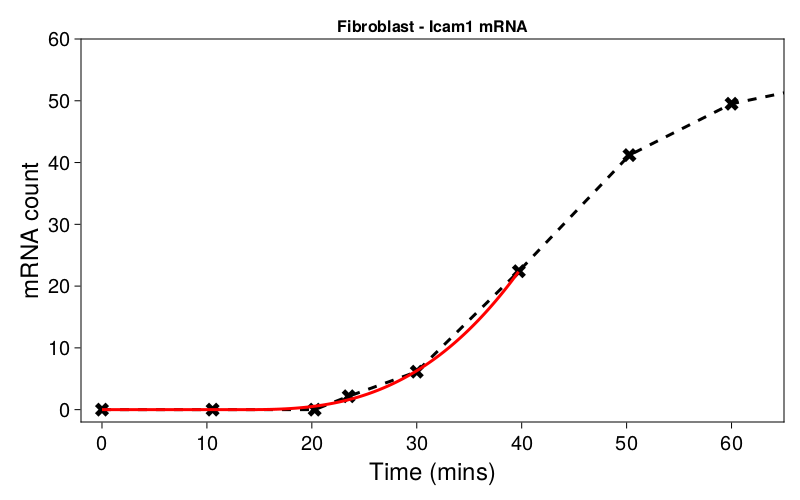

In [82]:
#plot mRNA count curve and regression

fig_2 = Figure(resolution = (800, 500))

#Data curve
ax = Axis(fig_2[1,1], xlabel="Time (mins)", ylabel="mRNA count",
          xlabelsize=24, xticklabelsize=20, ylabelsize=24, yticklabelsize=20, title="Fibroblast - Icam1 mRNA")
CairoMakie.scatterlines!(times_vec_2, RNAcount_vec, color=:black, marker=:xcross, markersize=20, linewidth=3, linestyle=:dash)
CairoMakie.lines!(x_range, mRNA_reg, color=:red, linewidth=3)
hidedecorations!(ax, ticks=false, ticklabels=false, label=false)
xlims!(-2, 65)
ylims!(-2, 60)

fig_2

In [ ]:
#compute the Jacobian of the model parameters evaluated at the optimal parameter set
#use this to estimate local uncertainties in the model parameters
#the terms in the Jacobian matrix depend on whether each time point falls during or after the delay

In [71]:
#function to evaluate the Jacobian of the model parameters at the optimal parameter set
#for model with 4 parameters inferred: prefactor (A_), exponent (n_), delay (t0_), m0_
#t_is - time points used to determine if a residual is before or after delay
function model_Jacobian_4params(A_, n_, t0_, m0_, t_is)
    
    N_params = 4; #number of model parameters
    N_obs = length(t_is); #number of observations
    
    #initialise Jacobian
    Jacobian = zeros(N_obs, N_params);
    
    for i in 1:1:N_obs
        
        #decide if observation lies during or after the delay
        if t_is[i] <= t0_ #if observation is during delay
            #then compute Jacobian using the derivatives computed during the delay
            #D[r_i, A_]
            Jacobian[i,1] = 0.0;
            #D[r_i, n_]
            Jacobian[i,2] = 0.0;
            #D[r_i, t0_]
            Jacobian[i,3] = 0.0;
            #D[r_i, m0_]
            Jacobian[i,4] = 1.0;
        else #observation is after delay
            #then compute Jacobian using the derivatives computed after the delay
            #D[r_i, A_]
            Jacobian[i,1] = ((t_is[i]-t0_)^n_)/gamma(n_);
            #D[r_i, n_]
            Jacobian[i,2] = (A_/gamma(n_))*((t_is[i]-t0_)^n_)*( log(t_is[i]-t0_)-polygamma(0,n_) ) ;
            #D[r_i, t0_]
            Jacobian[i,3] = ((-A_*n_)/gamma(n_))*((t_is[i]-t0_)^(n_-1));
            #D[r_i, m0_]
            Jacobian[i,4] = 1.0;
        end
        
    end
    
    return Jacobian;
    
end

model_Jacobian_4params (generic function with 1 method)

In [72]:
#function to evaluate the Jacobian of the model parameters at the optimal parameter set
#for model with 3 parameters inferred: prefactor (A_), exponent (n_), m0_
#t_is - time points used to determine if a residual is before or after delay
function model_Jacobian_3params(A_, n_, t0_, m0_, t_is)
    
    N_params = 3; #number of model parameters
    N_obs = length(t_is); #number of observations
    
    #initialise Jacobian
    Jacobian = zeros(N_obs, N_params);
    
    for i in 1:1:N_obs
        
        #decide if observation lies during or after the delay
        if t_is[i] <= t0_ #if observation is during delay
            #then compute Jacobian using the derivatives computed during the delay
            #D[r_i, A_]
            Jacobian[i,1] = 0.0;
            #D[r_i, n_]
            Jacobian[i,2] = 0.0;
            #D[r_i, m0_]
            Jacobian[i,3] = 1.0;
        else #observation is after delay
            #then compute Jacobian using the derivatives computed after the delay
            #D[r_i, A_]
            Jacobian[i,1] = ((t_is[i]-t0_)^n_)/gamma(n_);
            #D[r_i, n_]
            Jacobian[i,2] = (A_/gamma(n_))*((t_is[i]-t0_)^n_)*( log(t_is[i]-t0_)-polygamma(0,n_) ) ;
            #D[r_i, m0_]
            Jacobian[i,3] = 1.0;
        end
        
    end
    
    return Jacobian;
    
end

model_Jacobian_3params (generic function with 1 method)

In [73]:
Jacobain_mRNA = model_Jacobian_4params(mRNA_prefactor, mRNA_exponent, mRNA_delay, mRNA_constant, times_vec_2[1:N_timepoints])

6×4 Matrix{Float64}:
    0.0      0.0       0.0       1.0
    0.0      0.0       0.0       1.0
  124.089    1.6934   -0.612378  1.0
  359.571    6.62128  -1.20505   1.0
 1405.23    34.4599   -2.86844   1.0
 4996.89   150.945    -6.42976   1.0

In [76]:
optim_RSS_mRNA = best_fitness(optim_res); #minimum RSS
#estimate of the variance of the residuals: RSS/(degrees of freedom)
var_of_residuals_mRNA = optim_RSS_mRNA/(length(times_vec_2[1:N_timepoints])-length(optim_ps_vec))

0.3217194226386038

In [77]:
cov_matrix_mRNA = inv(transpose(Jacobain_mRNA)*Jacobain_mRNA)*var_of_residuals_mRNA

4×4 Matrix{Float64}:
  0.000262573  -0.00669332   0.0474853   0.00274058
 -0.00669332    0.170958    -1.20262    -0.0661704
  0.0474853    -1.20262      8.78127     0.60118
  0.00274058   -0.0661704    0.60118     0.158617

In [80]:
std_err_params_vec_mRNA = sqrt.(diag(cov_matrix_mRNA))

4-element Vector{Float64}:
 0.016204092911732637
 0.4134701834754767
 2.963319937555043
 0.39826743326652025